# Importing Libraries

In [4]:
from tensorflow.keras.models import model_from_json
from fer_model import get_fer_model
import tensorflow as tf
import tempfile 

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

# Loading the CK+ Dataset

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DATASET_DIR = "/Users/samuilstoychev/ckplus_cropped/"

img_size = 48
batch_size = 32

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(DATASET_DIR + "train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(DATASET_DIR + "test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 1050 images belonging to 8 classes.
Found 258 images belonging to 8 classes.


# 1. Load the Trained Baseline Model 
Trained and stored in the `ModelTraining` Jupyter Notebook. 

In [3]:
model = get_fer_model()
model.load_weights("model_weights.h5")

In [4]:
print("BASELINE ACCURACY!")
model.evaluate(validation_generator)

BASELINE ACCURACY!
9/9 [==============================] - 3s 340ms/step - loss: 0.5191 - accuracy: 0.8101


[0.5191005700164371, 0.81007755]

### Store baseline as a file (for future reference). 

In [5]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /var/folders/vg/_5hx2l0n6n99wl67355lydtr0000gn/T/tmpk8zpxnfv.h5


# 2. Apply Compression

In [6]:
import tensorflow_model_optimization as tfmot

In [7]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Note: Need to calculate `begin_step` and `end_step` properly! 

In [8]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                            final_sparsity=0.80, 
                                                            begin_step=0, 
                                                            end_step=1000)
}   

In [9]:
model_for_pruning = prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [10]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0005)

model_for_pruning.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 48, 48, 64)        1218      
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 64)        257       
_________________________________________________________________
prune_low_magnitude_activati (None, 48, 48, 64)        1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 24, 24, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 24, 24, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 24, 24, 128)       409730    
_________________________________________________________________
prune_low_magnitude_batch_no (None, 24, 24, 128)       5

### Note: Export this to a function in a separate file. 

## NOTE: Replicate training process more accurately! 
E.g., add `steps_per_epoch`. 

# FINE-TUNING!!! 
**TODO:** Fix the weight saving! 

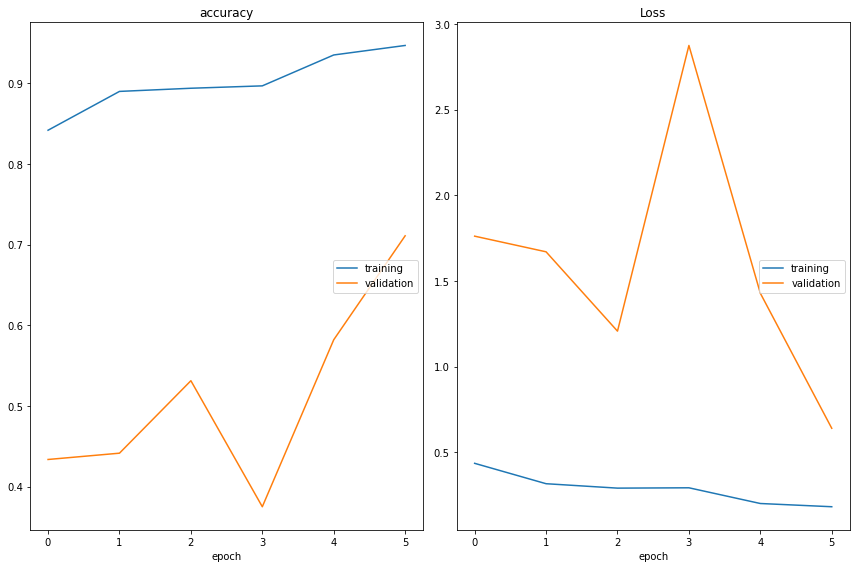

accuracy
	training         	 (min:    0.842, max:    0.947, cur:    0.947)
	validation       	 (min:    0.375, max:    0.711, cur:    0.711)
Loss
	training         	 (min:    0.181, max:    0.435, cur:    0.181)
	validation       	 (min:    0.639, max:    2.874, cur:    0.639)

Epoch 00006: saving model to pruned_model_weights.h5
32/32 [==============================] - 26s 807ms/step - loss: 0.1818 - accuracy: 0.9470 - val_loss: 0.6394 - val_accuracy: 0.7109
CPU times: user 6min 18s, sys: 2min 35s, total: 8min 54s
Wall time: 2min 50s


In [11]:
# %%time

# logdir = tempfile.mkdtemp()

# epochs = 6
# steps_per_epoch = train_generator.n//train_generator.batch_size
# validation_steps = validation_generator.n//validation_generator.batch_size

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2, min_lr=0.00001, mode='auto')
# checkpoint = ModelCheckpoint("pruned_model_weights.h5", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
# callbacks = [PlotLossesKerasTF(), 
#              checkpoint, 
#              reduce_lr, 
#              tfmot.sparsity.keras.UpdatePruningStep(),
#              tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]

# history = model_for_pruning.fit(
#     x=train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data = validation_generator,
#     validation_steps = validation_steps,
#     callbacks=callbacks
# )

# Load the best weights (from fine-tuning)

In [12]:
model_for_pruning.load_weights("pruned_model_weights.h5")

In [13]:
model_for_pruning.evaluate(validation_generator)

9/9 [==============================] - 2s 265ms/step - loss: 0.5784 - accuracy: 0.7171


[0.5783951559828387, 0.71705425]

In [14]:
# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# pruning_history = model_for_pruning.fit(
#     x=train_generator,
#     epochs=2,
#     validation_data = validation_generator,
#     callbacks=callbacks
# )

In [15]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /var/folders/vg/_5hx2l0n6n99wl67355lydtr0000gn/T/tmpyistwsq9.h5


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /var/folders/vg/_5hx2l0n6n99wl67355lydtr0000gn/T/tmp6uaxno_b.tflite


In [17]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [18]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 16523420.00 bytes
Size of gzipped pruned Keras model: 8906421.00 bytes
Size of gzipped pruned TFlite model: 8863840.00 bytes


In [19]:
model_for_pruning.evaluate(validation_generator)

9/9 [==============================] - 3s 279ms/step - loss: 0.5527 - accuracy: 0.7287


[0.552737472164962, 0.72868216]

# 3. Fine-Tune the Pruned Model
https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras